In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os

In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

In [2]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Generate dataset using the second derivative instead of the first

The code currently loads a previously created dataset instead of creating a new one each time.

In [3]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives, self.second_derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        first_derivatives = []
        second_derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

            d2y_dx2 = torch.autograd.grad(outputs=dy_dx, inputs=self.x, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
            second_derivatives.append(d2y_dx2.detach().numpy())

        return np.array(functions), np.array(first_derivatives), np.array(second_derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx]), torch.FloatTensor(self.second_derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000

# Uncomment below to create dataset
# dataset = FourierSeriesDataset(num_samples, num_points)

# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# torch.save(dataset, 'datasets/both_derivatives_dataset.pt')

## Load previously saved dataset

In [4]:
dataset = torch.load('datasets/both_derivatives_dataset.pt')

In [5]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [7]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


In [8]:
first_batch = next(iter(train_dataloader))
num_elements = len(first_batch)
print(f"Number of elements in each batch: {num_elements}")

Number of elements in each batch: 3


In [9]:
inputs = first_batch[0]  # Assuming first element is inputs
print(f"Batch shape: {inputs.shape}")

Batch shape: torch.Size([32, 1000])


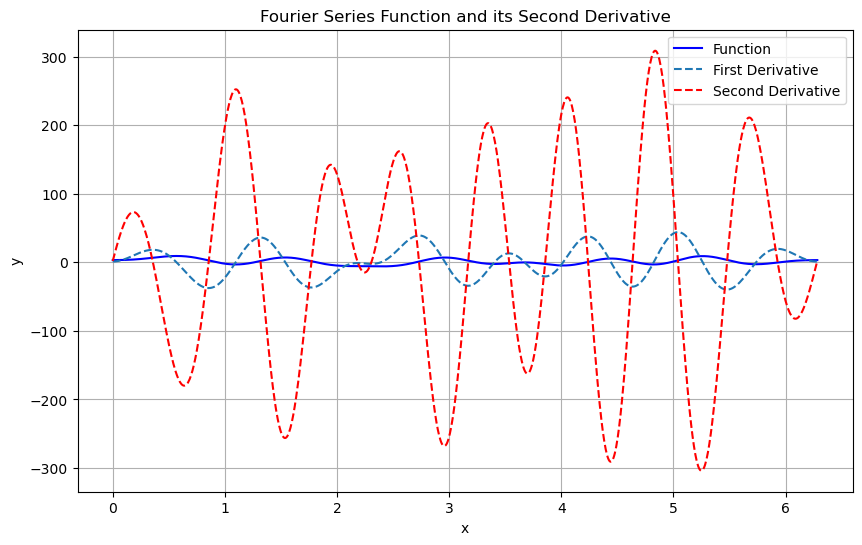

In [10]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative, second_derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()
    second_derivative = second_derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    plt.plot(x, second_derivative, label='Second Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Second Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)

def get_random_function(shuffle=True):
    return DataLoader(train_dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(shuffle=False)
plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

In [11]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize the model, loss function, and optimizer
model1 = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters())

## Load in previously saved model weights

In [12]:
# to use model from cluster, use
model1.load_state_dict(torch.load('models/first_stage_1000epochs_first_derivative_weights.pth'))


<All keys matched successfully>

## Training loop

In [13]:
# Training loop
train_losses = []
test_losses = []

def first_stage_training(num_epochs):
    for epoch in range(num_epochs):
        model1.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives, _ in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model1(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model1.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives, _ in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model1(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print("Training finished!")

In [14]:
# Uncomment below to train and save the model
# first_stage_training(10)
# torch.save(model1.state_dict(), 'models/first_stage_1000epochs_first_derivative_weights.pth')

In [15]:
def plot_losses(train_losses, test_losses, save_dir='plots', xmin=None, ymax=None, filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

Uncomment below to plot losses after training

In [16]:
# plot_losses(train_losses=train_losses, test_losses=test_losses, filename='first_stage_first_derivative_loss')

In [39]:
def plot_sliced(x, y, label, linestyle='-'):
    plt.plot(x[10:-10], y[10:-10], label=label, linestyle=linestyle)


In [42]:
def plot_output(model1, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative, true_second_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        predicted_derivative = model1(function)
        predicted_second_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()
    true_derivative = true_derivative.squeeze().numpy()
    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_second_derivative = true_second_derivative.squeeze().numpy()
    predicted_second_derivative = predicted_second_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(x, function, label='Original Function', color='blue')
    plt.plot(x, true_derivative, label='True 1st Derivative')
    plt.plot(x, predicted_derivative, label='Predicted 1st Derivative', linestyle='--')
    plt.plot(x, true_second_derivative, label='True 2nd Derivative')
    plt.plot(x, predicted_second_derivative, label='Predicted 2nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

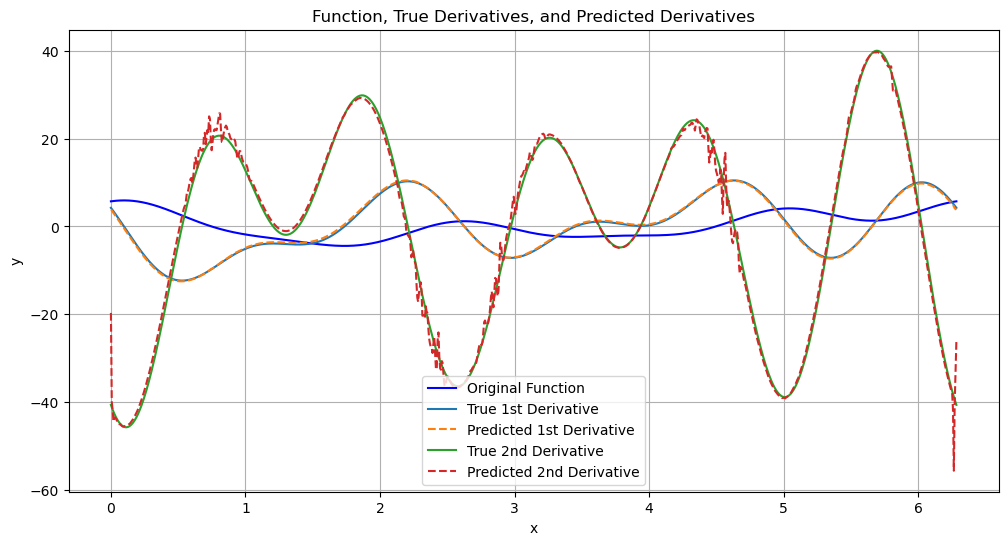

In [47]:
plot_output(model1, save_dir='plots', filename='rollout_output')

## Ground truth - model output

In [64]:
def plot_difference(model1, save_dir='plots', filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model1.eval()  # Set the model to evaluation mode

    plt.figure(figsize=(12, 12))  # Adjust figure size for a 2x2 grid
    
    for i in range(1, 5):  # Loop over four different functions
        train_dataloader_viz = get_random_function(shuffle=True)
        dataiter = iter(train_dataloader_viz)
        function, true_derivative, true_second_derivative = next(dataiter)

        function = function.unsqueeze(1)  # Add channel dimension

        # Make prediction
        with torch.no_grad():
            predicted_derivative = model1(function)
            first_deriv_diff = predicted_derivative - true_derivative

            predicted_second_derivative = model1(predicted_derivative)
            second_deriv_diff = predicted_second_derivative - true_second_derivative

        # Convert tensors to numpy arrays for plotting
        x = torch.linspace(0, 2*torch.pi, 1000).numpy()
        function = function.squeeze().numpy()
        first_deriv_diff = first_deriv_diff.squeeze().numpy()
        second_deriv_diff = second_deriv_diff.squeeze().numpy()
        true_second_derivative = true_second_derivative.squeeze().numpy()

        plt.subplot(2, 2, i)  # Adjust subplot position
        plot_sliced(x, function, 'Original Function')
        plot_sliced(x, first_deriv_diff, '1st Derivative Difference', linestyle='--')
        # plot_sliced(x, true_second_derivative, 'True 2nd derivative', linestyle='--')

        plt.title(f'Difference for Function {i}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

    if save:
        save_path = os.path.join(save_dir, filename if filename else 'multi_plot.png')
        plt.savefig(save_path)
    plt.show()


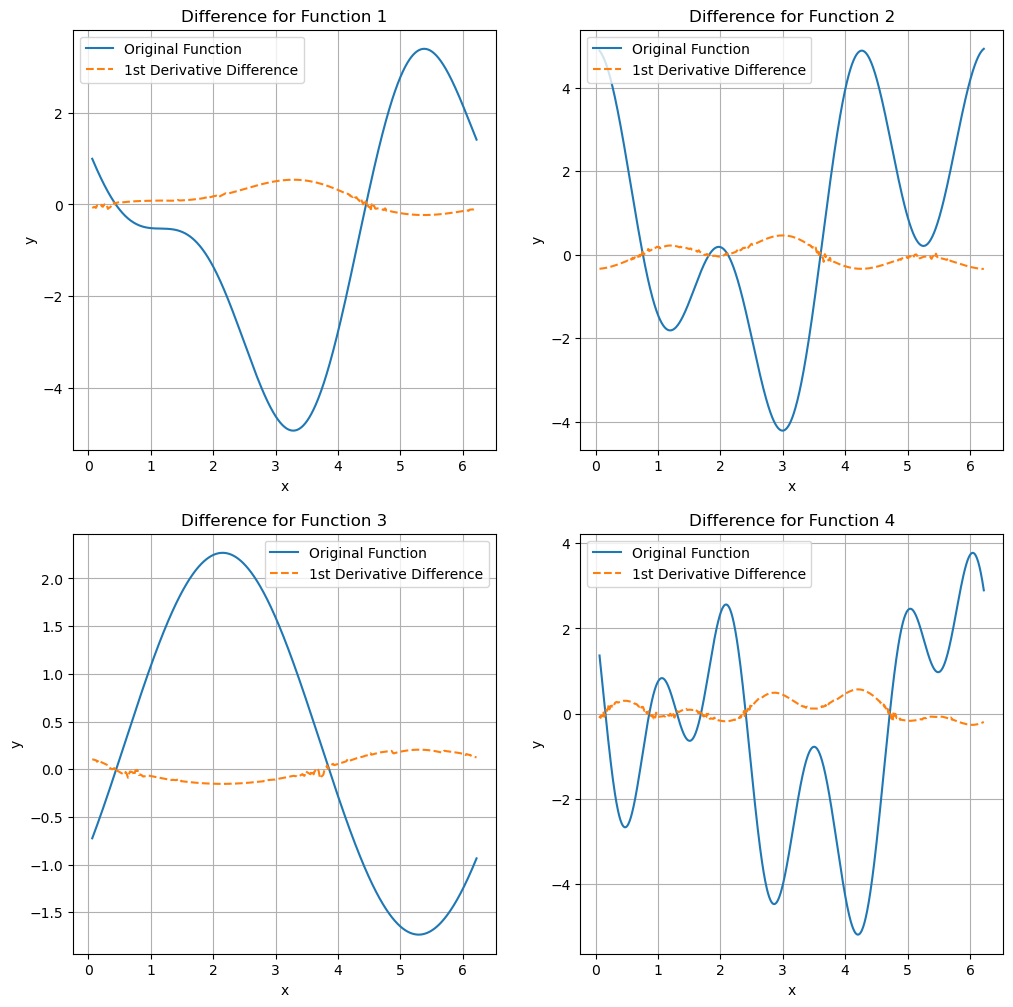

In [66]:
plot_difference(model1, save_dir='plots', filename='multi_difference_output', save=True)

## Calculate accuracy (MSE)

In [19]:
def compute_mse(dataloader, model1, model2=None):
    model1.eval()

    mse1_accumulator = 0.0
    mse2_accumulator = 0.0

    n_batches = 0

    # Inspect the first batch to determine the number of elements
    first_batch = next(iter(dataloader))
    num_elements = len(first_batch)
    
    print(f"Number of elements in each batch: {num_elements}")

    for batch in dataloader:
        if num_elements == 2:
            x, y = batch
        elif num_elements == 3:
            x, y, sec_deriv = batch
            sec_deriv = sec_deriv[:, 10:-10]
        else:
            raise ValueError(f"Unexpected number of elements in batch: {num_elements}")

        x = x[:, 10:-10].unsqueeze(1)
        y = y[:, 10:-10].unsqueeze(1)
        
        if model2:
            model_output = calculate_combined_output(model1, model2, x, y)
        else:
            model_output = model1(x)
            model_rollout = model1(model_output)

        mse1 = torch.mean((model_output - y) ** 2, dim=2) 
        mse2 = torch.mean((model_rollout - sec_deriv) ** 2, dim=2)

        mse1_accumulator += mse1.mean().item()  
        mse2_accumulator += mse2.mean().item()
        n_batches += 1

    overall_mse1 = mse1_accumulator / n_batches
    overall_mse2 = mse2_accumulator / n_batches

    print(f"Overall MSE1 over all test functions: {overall_mse1}")
    print(f"Overall MSE2 over all test functions: {overall_mse2}")

    return overall_mse1, overall_mse2
compute_mse(test_dataloader, model1)

Number of elements in each batch: 3
Overall MSE1 over all test functions: 0.11637246656802393
Overall MSE2 over all test functions: 20514.178506174394


(0.11637246656802393, 20514.178506174394)

MSE for second stage is much higher than I expect

## Spectral biases from Fourier Transform

In [24]:
def calculate_median_frequency(function):
    fft_coeffs = np.fft.fft(function)
    freqs = np.fft.fftfreq(len(function))
    power_spectrum = np.abs(fft_coeffs)**2
    significant_freqs = freqs[power_spectrum > (np.max(power_spectrum) * 0.01)]
    return np.median(np.abs(significant_freqs))

def categorize_functions(dataloader):
    functions_with_freqs = []
    
    for functions, derivatives, sec_derivative in dataloader:
        for idx, function in enumerate(functions):
            median_frequency = calculate_median_frequency(function.numpy())
            functions_with_freqs.append((function.numpy(), derivatives[idx].numpy(), sec_derivative[idx].numpy(), median_frequency))
    
    # Sort by median frequency
    functions_with_freqs.sort(key=lambda x: x[3])
    
    # Split into low and high frequency datasets
    mid_index = len(functions_with_freqs) // 2
    low_freq_dataset = functions_with_freqs[:mid_index]
    high_freq_dataset = functions_with_freqs[mid_index:]
    
    # Create new DataLoaders, excluding the median frequency from the data
    # Each dataloader contains the function, deriv, and second deriv
    low_freq_dataloader = DataLoader([(f[0], f[1], f[2]) for f in low_freq_dataset])
    high_freq_dataloader = DataLoader([(f[0], f[1], f[2]) for f in high_freq_dataset])
    
    return low_freq_dataloader, high_freq_dataloader

In [25]:
# use the test dataset to compute frequencies
# Should be half of full dataset in each dataloader
low_freq_dataset, high_freq_dataset = categorize_functions(test_dataloader)

print(f"Low frequency dataset size: {len(low_freq_dataset)}")
print(f"High frequency dataset size: {len(high_freq_dataset)}")

Low frequency dataset size: 992
High frequency dataset size: 992


In [26]:
low_freq_mse = compute_mse(low_freq_dataset, model1)

Number of elements in each batch: 3
Overall MSE1 over all test functions: 0.06299745544005887
Overall MSE2 over all test functions: 16.819894161676206


In [27]:
high_freq_mse = compute_mse(high_freq_dataset, model1)

Number of elements in each batch: 3
Overall MSE1 over all test functions: 0.16974733846126905
Overall MSE2 over all test functions: 402.274332433218
